In [1]:
"""
Active Learning CIFAR-10 - Google Colab Version
Copy this entire file into a Colab notebook cell
"""

# ============================================================
# CELL 1: Setup and Mount Google Drive + reproducibility
# ============================================================

!pip install scikit-learn -q

from google.colab import drive
drive.mount('/content/drive')

import os, sys, time
SAVE_DIR = '/content/drive/MyDrive/AL_Results'
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Results will be saved to: {SAVE_DIR}")

# Verify GPU
import torch
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    try:
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    except Exception:
        pass

# ---------- reproducibility helpers ----------
import random, copy
import numpy as np

def set_all_seeds(seed):
    """Seed python, numpy, torch (CPU & CUDA) for reproducibility.
       Note: setting deterministic flags may slow training slightly."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    try:
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass
    # Make cuDNN deterministic (may slow). Keep explicit.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def make_initial_model_state(device):
    """Return a state_dict for SimpleCNN to use as the common initial weights."""
    m = SimpleCNN().to(device)
    state = copy.deepcopy(m.state_dict())
    del m
    return state

def load_state_into_model(model, state_dict, device):
    model.load_state_dict(state_dict)
    model.to(device)
    return model

# DataLoader worker initialization for determinism
def worker_init_fn(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % (2**32)
    np.random.seed(worker_seed)
    random.seed(worker_seed)


Mounted at /content/drive
Results will be saved to: /content/drive/MyDrive/AL_Results
GPU available: True
GPU: Tesla T4


In [ ]:
# ============================================================
# CELL 2: Main code (AL simulation)
# ============================================================
import argparse, os, copy, math, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import accuracy_score

class SimpleCNN(nn.Module):
    def __init__(self, embedding_dim=128, num_classes=10):
        super().__init__()
        # Layer 1: Conv -> BN -> ReLU -> Pool
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        # Layer 2: Conv -> BN -> ReLU -> Pool
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Layer 3: Conv -> BN -> ReLU -> Pool
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1) # Kept at 64 to save params, or go 128
        self.bn3 = nn.BatchNorm2d(64)

        # Classifier
        self.fc1 = nn.Linear(64 * 4 * 4, embedding_dim) # 64 channels * 4x4 image size
        self.fc2 = nn.Linear(embedding_dim, num_classes)

    def forward(self, x, return_embedding=False):
        # Block 1, 2 and 3
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = x.view(x.size(0), -1)

        # Embedding & Logits
        embedding = F.relu(self.fc1(x))
        logits = self.fc2(embedding)

        return (logits, embedding) if return_embedding else logits

# ------------------------
# Training & Eval
# ------------------------
def train_epoch(model, dataloader, device, optimizer, criterion=nn.CrossEntropyLoss()):
    model.train()
    total_loss = 0.0
    n = 0
    for x,y in dataloader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        n += x.size(0)
    return total_loss / max(1, n)

def evaluate(model, dataloader, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x,y in dataloader:
            x = x.to(device)
            p = model(x).argmax(1).cpu().numpy()
            preds.append(p)
            trues.append(y.numpy())
    return accuracy_score(np.concatenate(trues), np.concatenate(preds))

# ------------------------
# Noisy annotator (use rng for determinism)
# ------------------------
def noisy_label(true_label, num_classes, epsilon, rng=None):
    if rng is None:
        rng = np.random
    if rng.rand() < epsilon:
        choices = list(range(num_classes))
        choices.remove(int(true_label))
        return int(rng.choice(choices))
    return int(true_label)

# ------------------------
# Query strategies (accept rng where needed)
# ------------------------
def query_random(unlabeled_indices, k, rng):
    return list(rng.choice(unlabeled_indices, size=k, replace=False))

def query_uncertainty(model, dataset, unlabeled_indices, k, device, batch_size=128):
    model.eval()
    # Subset temporarily; unlabeled_indices are absolute indices into dataset.base
    loader = DataLoader(Subset(dataset, unlabeled_indices), batch_size=batch_size, shuffle=False)
    scores, idx_list = [], []
    base = 0
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            probs = F.softmax(model(xb), dim=1)
            unc = (1.0 - probs.max(1)[0]).cpu().numpy()
            scores.append(unc)
            # Compute indices corresponding to this batch
            batch_inds = unlabeled_indices[base: base + xb.size(0)]
            idx_list.extend(batch_inds)
            base += xb.size(0)
    scores = np.concatenate(scores)
    order = np.argsort(-scores)  # Descending uncertainty
    chosen = np.array(idx_list)[order[:k]].tolist()
    return chosen

def extract_embeddings(model, dataset, indices, device, batch_size=128):
    model.eval()
    loader = DataLoader(Subset(dataset, indices), batch_size=batch_size, shuffle=False)
    emb_list = []
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            _, emb = model(xb, return_embedding=True)
            emb_list.append(emb.cpu().numpy())
    if len(emb_list) == 0:
        return np.zeros((0, 128))
    return np.vstack(emb_list)

def query_diversity_kmeans(model, dataset, unlabeled_indices, k, device, rng=None, n_clusters=None, use_minibatch=True):
    if rng is None:
        rng = np.random.RandomState()
    if n_clusters is None:
        n_clusters = k
    if len(unlabeled_indices) == 0:
        return []
    embeddings = extract_embeddings(model, dataset, unlabeled_indices, device)
    if embeddings.shape[0] == 0:
        return []
    # use MiniBatchKMeans as faster alternative when pool large
    try:
        if use_minibatch:
            km = MiniBatchKMeans(n_clusters=min(n_clusters, embeddings.shape[0]), random_state=rng.randint(1<<31)).fit(embeddings)
        else:
            km = KMeans(n_clusters=min(n_clusters, embeddings.shape[0]), random_state=rng.randint(1<<31)).fit(embeddings)
    except Exception:
        km = KMeans(n_clusters=min(n_clusters, embeddings.shape[0]), random_state=rng.randint(1<<31)).fit(embeddings)
    centers = km.cluster_centers_
    chosen = []
    for ci in range(km.n_clusters):
        cluster_idx = np.where(km.labels_==ci)[0]
        if len(cluster_idx)==0:
            continue
        pts = embeddings[cluster_idx]
        dists = np.linalg.norm(pts - centers[ci], axis=1)
        chosen.append(int(unlabeled_indices[cluster_idx[dists.argmin()]]))
        if len(chosen) >= k:
            break
    if len(chosen) < k:
        remaining = list(set(unlabeled_indices) - set(chosen))
        if remaining:
            pad = list(rng.choice(remaining, size=min(len(remaining), k-len(chosen)), replace=False))
            chosen.extend(list(map(int, pad)))
    return chosen[:k]

# ------------------------
# Dataset wrapper (NoisyLabelDataset)
# ------------------------
class NoisyLabelDataset(Dataset):
    """Wraps an underlying torchvision-style dataset. The base dataset should
       expose `.targets` and index with absolute indices.
       Use .noisy_label_map to set noisy labels (mapping absolute_index -> noisy_label)."""
    def __init__(self, base_dataset):
        self.base = base_dataset
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        x, y_true = self.base[idx]
        y = getattr(self.base, 'noisy_label_map', {}).get(idx, y_true)
        return x, y

# ------------------------
# Single AL simulation
# ------------------------
def run_single_simulation(dataset_train, dataset_test, initial_labeled_indices,
                          strategy, labeling_budget, batch_size_query, device,
                          epsilon, seed, max_epochs=10, early_stopping=True,
                          patience=3, verbose=True, init_state=None, rng=None):
    """
    init_state: state_dict for model initial weights (for CRN)
    rng: numpy RandomState for this run (for deterministic noisy labels & selection)
    """
    if rng is None:
        rng = np.random.RandomState(seed)
    set_all_seeds(seed)
    labeled_set = list(initial_labeled_indices)[:] # Absolute indices into dataset_train.base
    all_indices = list(range(len(dataset_train)))
    unlabeled_set = list(sorted(set(all_indices) - set(labeled_set)))
    results = []

    # Build model with init state for CRN
    model = SimpleCNN().to(device)
    if init_state is not None:
        model.load_state_dict(init_state)

    def make_labeled_loader():
        # Use worker_init_fn to keep deterministic worker seeds if num_workers>0
        return DataLoader(Subset(dataset_train, labeled_set), batch_size=64, shuffle=True, worker_init_fn=worker_init_fn)
    test_loader = DataLoader(dataset_test, batch_size=256, shuffle=False)

    round_num = 0
    while True:
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

        best_acc = 0.0
        patience_counter = 0

        for epoch in range(max_epochs):
            train_loss = train_epoch(model, make_labeled_loader(), device, optimizer)
            if early_stopping and epoch > 0:
                current_acc = evaluate(model, make_labeled_loader(), device)
                scheduler.step(current_acc)

                if current_acc > best_acc:
                    best_acc = current_acc
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience and epoch >= 5:
                    if verbose:
                        print(f"  Early stopping at epoch {epoch+1}")
                    break

        acc = evaluate(model, test_loader, device)
        results.append((len(labeled_set), acc))

        if verbose:
            print(f"Round {round_num}: {len(labeled_set)} labels, accuracy={acc:.4f}")

        if len(labeled_set) >= labeling_budget or len(unlabeled_set) == 0:
            break

        k = min(batch_size_query, labeling_budget - len(labeled_set))
        if strategy == 'random':
            chosen = query_random(np.array(unlabeled_set), k, rng)
        elif strategy == 'uncertainty':
            chosen = query_uncertainty(model, dataset_train, np.array(unlabeled_set), k, device)
        elif strategy == 'diversity':
            chosen = query_diversity_kmeans(model, dataset_train, np.array(unlabeled_set), k, device, rng=rng)
        else:
            raise ValueError("Unknown strategy")

        annotated = []
        base = dataset_train.base
        for idx in chosen:
            true_label = base.targets[int(idx)]
            noisy = noisy_label(true_label, 10, epsilon, rng=rng)
            annotated.append((int(idx), noisy))

        if not hasattr(dataset_train.base, 'noisy_label_map'):
            dataset_train.base.noisy_label_map = {}
        for idx, lab in annotated:
            dataset_train.base.noisy_label_map[int(idx)] = int(lab)

        # Update sets
        labeled_set.extend(list(map(int, chosen)))
        unlabeled_set = [i for i in unlabeled_set if i not in set(map(int, chosen))]

        del model, optimizer, scheduler
        torch.cuda.empty_cache()
        model = SimpleCNN().to(device)
        if init_state is not None:
            model.load_state_dict(init_state)
        round_num += 1

    del model
    torch.cuda.empty_cache()

    return results

# ------------------------
# Main experiment runner
# ------------------------
def run_experiment(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Add RandomHorizontalFlip and RandomCrop
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    cifar_train_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    cifar_test_full = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Optionally use a subset (preserve absolute indices by creating a mapping)
    if config.get('subset') is not None:
        subset_n = config['subset']
        assert subset_n <= len(cifar_train_full)
        subset_indices = list(range(subset_n))
        cifar_train = Subset(cifar_train_full, subset_indices)
        # make a small wrapper that preserves `.targets` for absolute indexing
        class SubsetWithTargets(Dataset):
            def __init__(self, subset, abs_indices):
                self.subset = subset
                self.abs_indices = abs_indices
                # expose targets aligned with absolute indexing
                self.targets = [cifar_train_full.targets[i] for i in abs_indices]
            def __len__(self): return len(self.subset)
            def __getitem__(self, idx):
                return self.subset[idx]
        cifar_train = SubsetWithTargets(cifar_train, subset_indices)
    else:
        cifar_train = cifar_train_full

    dataset_train = NoisyLabelDataset(cifar_train)
    dataset_test = NoisyLabelDataset(cifar_test_full)

    strategies = config['strategies']
    save_dir = config['save_dir']
    os.makedirs(save_dir, exist_ok=True)

    print(f"Experiment configuration:")
    print(f"  Dataset size: {len(dataset_train)}")
    print(f"  Initial labels: {config['initial_labels']}")
    print(f"  Labeling budget: {config['labeling_budget']}")
    print(f"  Max epochs: {config['max_epochs']}")
    print(f"  Strategies: {strategies}")
    print(f"  Epsilon values: {config['epsilons']} (if sampling enabled, values may be drawn per-replication)")
    print(f"  Replications: {config['replications']}")
    print(f"  Save directory: {save_dir}")

    total_experiments = len(config['epsilons']) * len(strategies) * config['replications']
    print(f"Total experiments (approx): {total_experiments}")

    start_time = time.time()
    completed = 0

    # For each epsilon in the grid (or if sampling, we'll ignore the grid and sample per replication)
    for epsilon in config['epsilons']:
        print(f"{'='*60}")
        print(f"Running epsilon = {epsilon}")
        print(f"{'='*60}")

        all_results = {s:[] for s in strategies}

        for rep in range(config['replications']):
            seed = config['seed'] + rep
            rng = np.random.RandomState(seed)
            # sample epsilon per replication if requested
            eps_this_rep = epsilon
            if config.get('sample_epsilon_per_rep', False):
                # example: uniform prior between 0 and given epsilon (or use explicit prior)
                eps_this_rep = float(rng.uniform(0.0, epsilon))

            initial_labeled = rng.choice(list(range(len(dataset_train))), size=config['initial_labels'], replace=False).tolist()

            # prepare CRN initial model state for this replication (same for all strategies)
            set_all_seeds(seed)
            init_state = make_initial_model_state(device)

            for s in strategies:
                # clear noisy labels
                if hasattr(dataset_train.base, 'noisy_label_map'):
                    dataset_train.base.noisy_label_map = {}

                print(f"  Rep {rep+1}/{config['replications']}, Strategy: {s}, eps={eps_this_rep:.4f}")
                rep_start = time.time()

                res = run_single_simulation(
                    dataset_train, dataset_test, initial_labeled,
                    strategy=s, labeling_budget=config['labeling_budget'],
                    batch_size_query=config['query_batch'], device=device,
                    epsilon=eps_this_rep, seed=seed, max_epochs=config['max_epochs'],
                    early_stopping=config['early_stopping'], patience=config['patience'],
                    verbose=config['verbose'], init_state=init_state, rng=rng
                )
                all_results[s].append(res)

                completed += 1
                elapsed = time.time() - rep_start
                total_elapsed = time.time() - start_time
                avg_time = total_elapsed / max(1, completed)
                remaining = (total_experiments - completed) * avg_time

                print(f"    Completed in {elapsed:.1f}s")
                print(f"    Progress: {completed}/{total_experiments} ({100*completed/total_experiments:.1f}%)")
                print(f"    Rough ETA (minutes): {remaining/60:.1f}")

        # Save results for this epsilon value
        fname = os.path.join(save_dir, f"al_results_e{int(epsilon*100)}.pkl")
        import pickle
        with open(fname,"wb") as f:
            pickle.dump(all_results,f)
        print(f"✓ Saved: {fname}")

    total_time = time.time() - start_time
    print(f"{'='*60}")
    print(f"All experiments completed! Total time: {total_time/3600:.2f} hours")
    print(f"Results saved to: {save_dir}")
    print(f"{'='*60}")

    return save_dir

print("✓ Code loaded successfully!")


✓ Code loaded successfully!


In [ ]:
# ============================================================
# CELL 3: Run Quick Validation (small subset, quick)
# ============================================================

config = {
    'save_dir': SAVE_DIR,
    'subset': None,
    'initial_labels': 100,
    'labeling_budget': 2000,
    'query_batch': 100,
    'max_epochs': 12,
    'strategies': ['random', 'uncertainty', 'diversity'],
    'epsilons': [0.0], # grid values; if sample_epsilon_per_rep=True, epsilons act as upper bound
    'replications': 1, # Keep at 1 for this test
    'seed': 123,
    'early_stopping': True,
    'patience': 3,
    'verbose': True,
    'sample_epsilon_per_rep': False # set True to draw epsilon ~ Uniform(0, eps) per replication
}

results_dir = run_experiment(config)
print(f"✓ Results saved to: {results_dir}")
print(f"Download these files from Google Drive to analyze locally:")
print(f"  {results_dir}/al_results_e0.pkl")


Using device: cuda


100%|██████████| 170M/170M [00:16<00:00, 10.5MB/s]


Experiment configuration:
  Dataset size: 50000
  Initial labels: 100
  Labeling budget: 2000
  Max epochs: 12
  Strategies: ['random', 'uncertainty', 'diversity']
  Epsilon values: [0.0] (if sampling enabled, values may be drawn per-replication)
  Replications: 1
  Save directory: /content/drive/MyDrive/AL_Results
Total experiments (approx): 3
Running epsilon = 0.0
  Rep 1/1, Strategy: random, eps=0.0000
  Early stopping at epoch 7
Round 0: 100 labels, accuracy=0.1477
Round 1: 200 labels, accuracy=0.3089
Round 2: 300 labels, accuracy=0.3198
Round 3: 400 labels, accuracy=0.3302
Round 4: 500 labels, accuracy=0.3786
Round 5: 600 labels, accuracy=0.3640
Round 6: 700 labels, accuracy=0.4071
Round 7: 800 labels, accuracy=0.4603
  Early stopping at epoch 10
Round 8: 900 labels, accuracy=0.4109
Round 9: 1000 labels, accuracy=0.4691
Round 10: 1100 labels, accuracy=0.4744
Round 11: 1200 labels, accuracy=0.4804
Round 12: 1300 labels, accuracy=0.5021
Round 13: 1400 labels, accuracy=0.5180
  Early

In [ ]:
# ============================================================
# CELL 4: Run Full Experiment (long)
# ============================================================

config_full = {
    'save_dir': SAVE_DIR,
    'subset': None,
    'initial_labels': 100,
    'labeling_budget': 2000,
    'query_batch': 100,
    'max_epochs': 10,
    'strategies': ['random', 'uncertainty', 'diversity'],
    'epsilons': [0.0, 0.05, 0.10, 0.15],  # grid
    'replications': 5,
    'seed': 123,
    'early_stopping': True,
    'patience': 3,
    'verbose': True,
    'sample_epsilon_per_rep': False  # set True to sample eps ~ Uniform(0, epsilon_grid_value) per replication
}

# Run full experiment (this can be long)
results_dir = run_experiment(config_full)
print(f"✓ Results saved to: {results_dir}")

Using device: cuda
Experiment configuration:
  Dataset size: 50000
  Initial labels: 100
  Labeling budget: 2000
  Max epochs: 10
  Strategies: ['random', 'uncertainty', 'diversity']
  Epsilon values: [0.0, 0.05, 0.1, 0.15] (if sampling enabled, values may be drawn per-replication)
  Replications: 5
  Save directory: /content/drive/MyDrive/AL_Results
Total experiments (approx): 60
Running epsilon = 0.0
  Rep 1/5, Strategy: random, eps=0.0000
  Early stopping at epoch 7
Round 0: 100 labels, accuracy=0.1477
Round 1: 200 labels, accuracy=0.2115
Round 2: 300 labels, accuracy=0.2934
Round 3: 400 labels, accuracy=0.3467
Round 4: 500 labels, accuracy=0.3758
Round 5: 600 labels, accuracy=0.3972
Round 6: 700 labels, accuracy=0.4337
Round 7: 800 labels, accuracy=0.4309
Round 8: 900 labels, accuracy=0.4073
Round 9: 1000 labels, accuracy=0.4551
Round 10: 1100 labels, accuracy=0.4594
Round 11: 1200 labels, accuracy=0.4397
  Early stopping at epoch 10
Round 12: 1300 labels, accuracy=0.4255
Round 13:

Found result files: ['al_results_e0.pkl', 'al_results_e5.pkl', 'al_results_e10.pkl', 'al_results_e15.pkl']


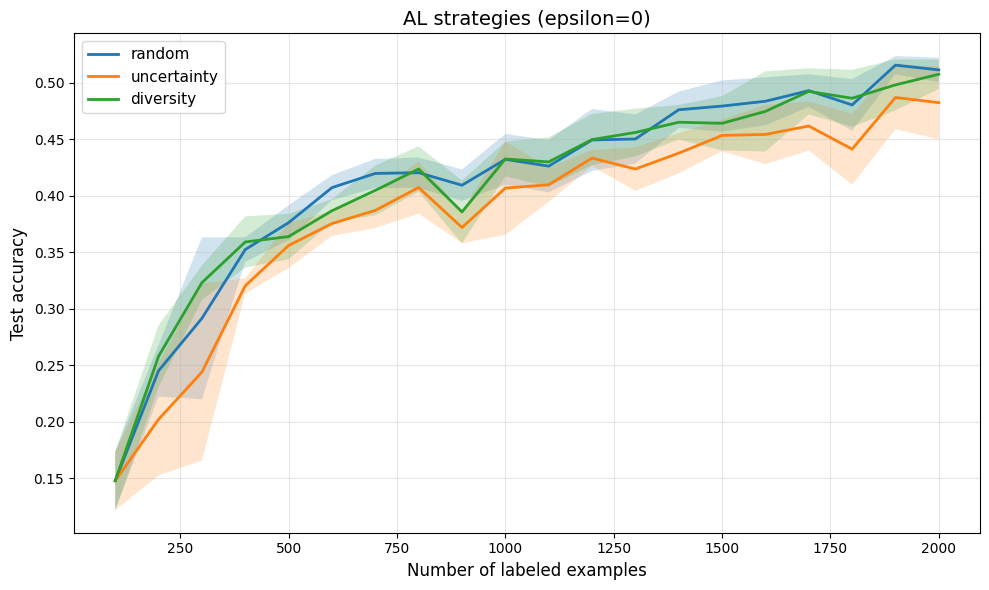

✓ Saved: /content/drive/MyDrive/AL_Results/summary_e0.json
✓ Saved: /content/drive/MyDrive/AL_Results/summary_e0.csv
✓ Saved: /content/drive/MyDrive/AL_Results/al_learning_curves_e0.png


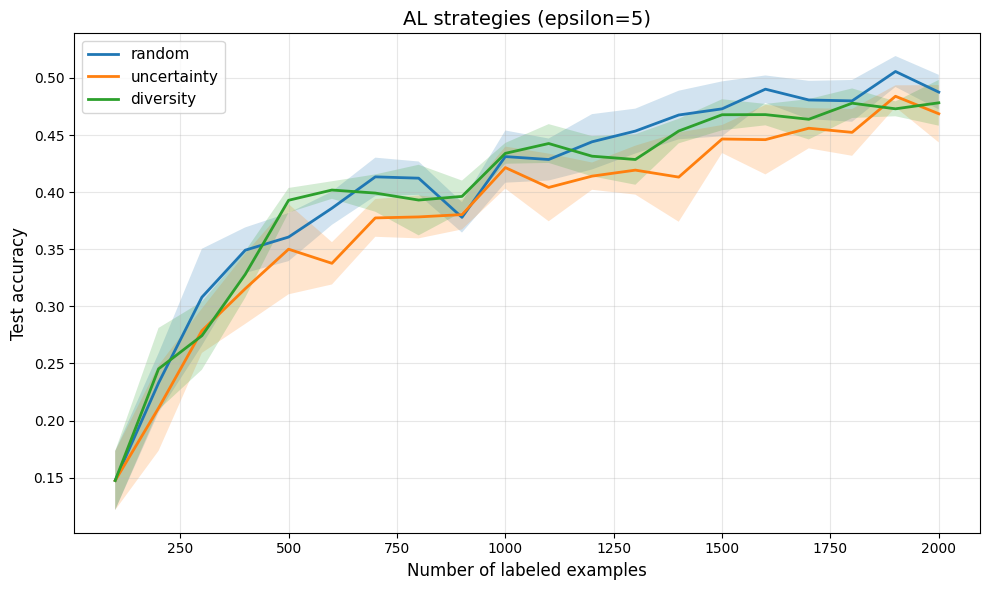

✓ Saved: /content/drive/MyDrive/AL_Results/summary_e5.json
✓ Saved: /content/drive/MyDrive/AL_Results/summary_e5.csv
✓ Saved: /content/drive/MyDrive/AL_Results/al_learning_curves_e5.png


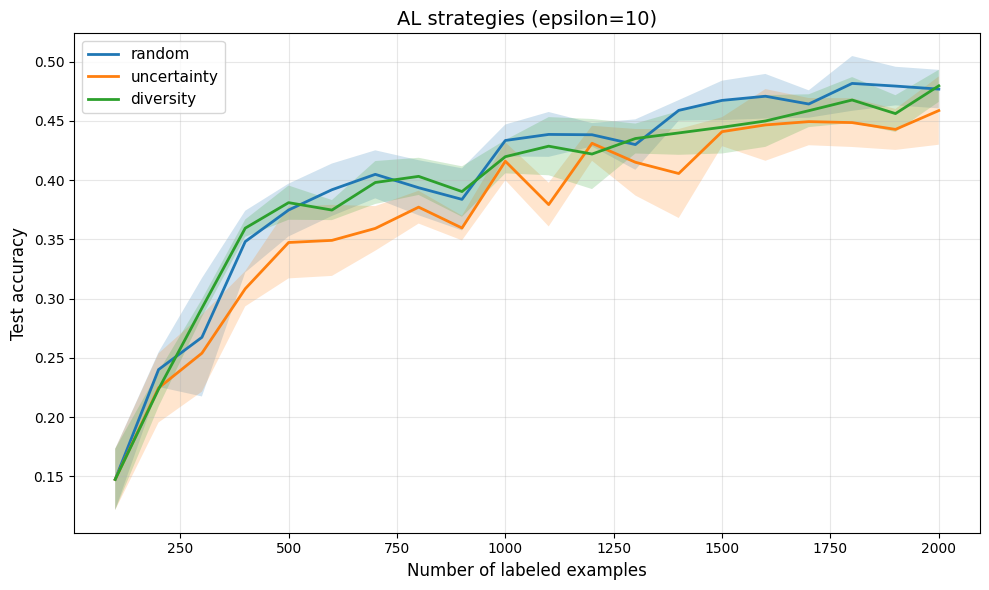

✓ Saved: /content/drive/MyDrive/AL_Results/summary_e10.json
✓ Saved: /content/drive/MyDrive/AL_Results/summary_e10.csv
✓ Saved: /content/drive/MyDrive/AL_Results/al_learning_curves_e10.png


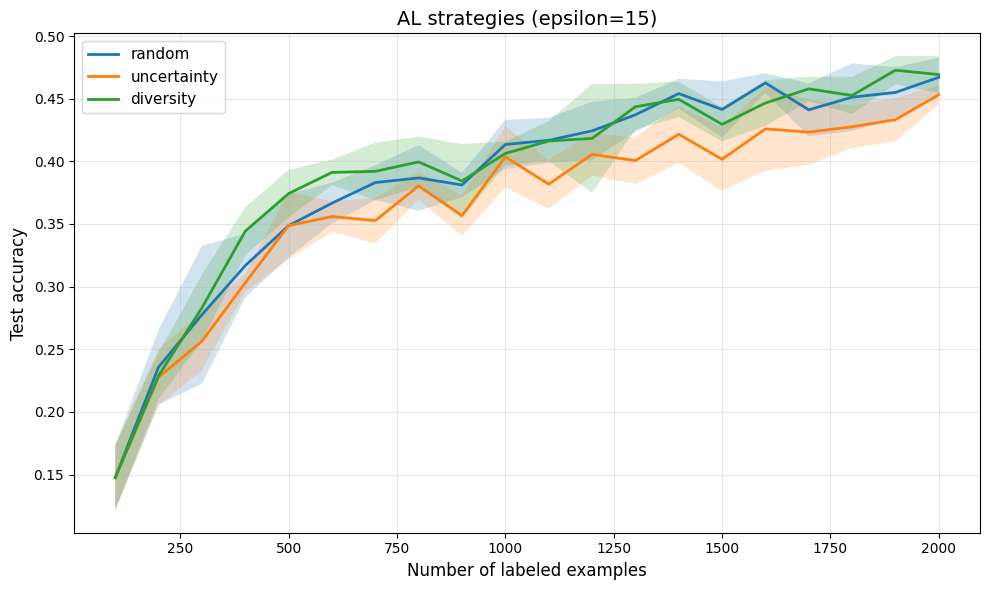

✓ Saved: /content/drive/MyDrive/AL_Results/summary_e15.json
✓ Saved: /content/drive/MyDrive/AL_Results/summary_e15.csv
✓ Saved: /content/drive/MyDrive/AL_Results/al_learning_curves_e15.png
All summaries generated and saved to: /content/drive/MyDrive/AL_Results


In [ ]:
# ============================================================
# CELL 5: Post-process and visualize
# ============================================================
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

SAVE_DIR = SAVE_DIR  # already defined

# helper to load result file for a given epsilon (int percent)
def load_results_for_epsilon(save_dir, e_percent):
    fname = os.path.join(save_dir, f"al_results_e{e_percent}.pkl")
    if not os.path.exists(fname):
        raise FileNotFoundError(f"{fname} not found")
    with open(fname, "rb") as f:
        all_results = pickle.load(f)
    return all_results

# process all saved result files found in SAVE_DIR matching pattern al_results_e*.pkl
files = [f for f in os.listdir(SAVE_DIR) if f.startswith('al_results_e') and f.endswith('.pkl')]
print(f"Found result files: {files}")

for f in files:
    path = os.path.join(SAVE_DIR, f)
    with open(path, "rb") as fh:
        all_results = pickle.load(fh)
    e_str = f.split('al_results_e')[-1].split('.pkl')[0]
    # normalize e label
    try:
        e_val = int(e_str)
    except Exception:
        e_val = e_str

    summary = {}
    for s in all_results:
        # collect all label counts from all reps
        labels_grid = sorted({n for rep in all_results[s] for n,_ in rep})
        mats = []
        for rep in all_results[s]:
            acc_map = {n:acc for n,acc in rep}
            # create accs aligned to labels_grid by forward-fill using last available
            accs = []
            for n in labels_grid:
                if n in acc_map:
                    accs.append(acc_map[n])
                else:
                    # find the largest key <= n
                    keys = [k for k in acc_map.keys() if k <= n]
                    if len(keys) == 0:
                        accs.append(0.0)
                    else:
                        accs.append(acc_map[max(keys)])
            mats.append(accs)
        mats = np.array(mats)
        mean = mats.mean(0)
        ci95 = 1.96 * mats.std(0, ddof=1) / np.sqrt(max(1, mats.shape[0]))
        summary[s] = {'labels': labels_grid, 'mean': mean.tolist(), 'ci': ci95.tolist()}

    # Save JSON
    json_path = os.path.join(SAVE_DIR, f"summary_e{e_val}.json")
    with open(json_path, "w") as fjson:
        json.dump(summary, fjson, indent=2)

    # Save CSV
    rows = []
    for s in summary:
        for n, m, c in zip(summary[s]['labels'], summary[s]['mean'], summary[s]['ci']):
            rows.append({"strategy": s, "labels": n, "accuracy_mean": m, "accuracy_ci95": c})
    csv_path = os.path.join(SAVE_DIR, f"summary_e{e_val}.csv")
    pd.DataFrame(rows).to_csv(csv_path, index=False)

    # Plot
    plt.figure(figsize=(10, 6))
    for s in summary:
        x = summary[s]['labels']
        y = summary[s]['mean']
        ci = summary[s]['ci']
        plt.plot(x, y, label=s, linewidth=2)
        plt.fill_between(x, np.array(y) - np.array(ci), np.array(y) + np.array(ci), alpha=0.2)
    plt.xlabel("Number of labeled examples", fontsize=12)
    plt.ylabel("Test accuracy", fontsize=12)
    plt.title(f"AL strategies (epsilon={e_val})", fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plot_path = os.path.join(SAVE_DIR, f"al_learning_curves_e{e_val}.png")
    plt.savefig(plot_path, dpi=200, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: {json_path}")
    print(f"✓ Saved: {csv_path}")
    print(f"✓ Saved: {plot_path}")

print(f"{'='*60}")
print(f"All summaries generated and saved to: {SAVE_DIR}")
print(f"{'='*60}")


My last message before I go to sleep. Hopefully it disconnects at a convenient point lol.

In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 16.4 MB/s eta 0:00:00


In [ ]:
# ============================================================
# CELL 6: READ + EXTRACT METRICS FROM PKL FILES
# ============================================================

import pickle
import pandas as pd
import os

SAVE_DIR = SAVE_DIR

pkl_files = [f for f in os.listdir(SAVE_DIR) if f.startswith("al_results_e") and f.endswith(".pkl")]
print("Found PKL files:", pkl_files)

records = []

for fname in pkl_files:
    # Extract epsilon from filename
    e_str = fname.split("al_results_e")[-1].split(".pkl")[0]
    epsilon = float(e_str)

    path = os.path.join(SAVE_DIR, fname)   # <-- FIXED HERE

    with open(path, "rb") as f:
        all_results = pickle.load(f)
        # structure: all_results[strategy] = [ replication -> list of (n_labels, accuracy) ]

    for strategy, reps in all_results.items():
        for rep_id, rep_data in enumerate(reps):
            for (n_labels, acc) in rep_data:
                records.append({
                    "epsilon": epsilon,
                    "strategy": strategy,
                    "rep": rep_id,
                    "labels": n_labels,
                    "accuracy": acc
                })

df = pd.DataFrame(records)
print(df.head())
print(df.shape)


Found PKL files: ['al_results_e0.pkl', 'al_results_e5.pkl', 'al_results_e10.pkl', 'al_results_e15.pkl']
   epsilon strategy  rep  labels  accuracy
0      0.0   random    0     100    0.1477
1      0.0   random    0     200    0.2115
2      0.0   random    0     300    0.2934
3      0.0   random    0     400    0.3467
4      0.0   random    0     500    0.3758
(1200, 5)


In [ ]:
# ============================================================
# CELL 7: Statistical analysis of AL strategies
# ============================================================

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print("Computing AULC for each strategy / epsilon / replication...")

# ---- Compute AULC per replication ----
aulc_rows = []
for (eps, strat, rep), g in df.groupby(["epsilon", "strategy", "rep"]):
    g_sorted = g.sort_values("labels")
    auc_val = np.trapz(g_sorted["accuracy"], g_sorted["labels"])
    aulc_rows.append({
        "epsilon": eps,
        "strategy": strat,
        "replication": rep,
        "aulc": auc_val
    })

aulc_df = pd.DataFrame(aulc_rows)
aulc_path = os.path.join(SAVE_DIR, "aulc_results.csv")
aulc_df.to_csv(aulc_path, index=False)
print("✓ Saved:", aulc_path)

# ---- Run ANOVA per epsilon level ----
anova_results = {}
tukey_results = {}

print("\n============================")
print("ANOVA PER EPSILON")
print("============================")

for eps, g in aulc_df.groupby("epsilon"):
    print(f"\n--- Epsilon = {eps:.2f} ---")

    model = ols("aulc ~ C(strategy)", data=g).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results[eps] = anova_table

    print(anova_table)

    # Tukey HSD
    tukey = pairwise_tukeyhsd(g["aulc"], g["strategy"])
    tukey_results[eps] = tukey
    print("\nPost-hoc Tukey HSD:")
    print(tukey)

# ---- Compute effect sizes ----

def etasquared(anova):
    return anova.loc["C(strategy)", "sum_sq"] / anova["sum_sq"].sum()

def cohend(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.var(x) + np.var(y)) / 2)

print("\n============================")
print("Effect Sizes")
print("============================")

for eps, g in aulc_df.groupby("epsilon"):
    print(f"\n--- Epsilon = {eps:.2f} ---")
    anova = anova_results[eps]
    eta2 = etasquared(anova)
    print(f"η² (effect size of strategy): {eta2:.3f}")

    for s1 in g["strategy"].unique():
        for s2 in g["strategy"].unique():
            if s1 >= s2:
                continue
            d = cohend(
                g[g.strategy == s1]["aulc"],
                g[g.strategy == s2]["aulc"]
            )
            print(f"Cohen's d ({s1} vs {s2}): {d:.3f}")


Computing AULC for each strategy / epsilon / replication...
✓ Saved: /content/drive/MyDrive/AL_Results/aulc_results.csv

ANOVA PER EPSILON

--- Epsilon = 0.00 ---
                 sum_sq    df         F    PR(>F)
C(strategy)  9147.43213   2.0  9.768867  0.003035
Residual     5618.31701  12.0       NaN       NaN


/tmp/ipython-input-1524081169.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_val = np.trapz(g_sorted["accuracy"], g_sorted["labels"])



Post-hoc Tukey HSD:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1     group2   meandiff p-adj   lower    upper   reject
--------------------------------------------------------------
diversity      random     5.63 0.9116 -30.8795  42.1395  False
diversity uncertainty  -49.343 0.0093 -85.8525 -12.8335   True
   random uncertainty  -54.973 0.0045 -91.4825 -18.4635   True
--------------------------------------------------------------

--- Epsilon = 5.00 ---
                  sum_sq    df          F    PR(>F)
C(strategy)  7290.050623   2.0  12.142397  0.001308
Residual     3602.279310  12.0        NaN       NaN

Post-hoc Tukey HSD:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1     group2   meandiff p-adj   lower    upper   reject
--------------------------------------------------------------
diversity      random   12.787 0.4939 -16.4472  42.0212  False
diversity uncertainty  -39.042 0.0101 -68.2762  -9.8078   True
   random uncertainty 

In [ ]:
# ============================================================
# CELL 8: Secondary Experiment: Uniform Random Epsilon per Rep
# ============================================================

# Use a small subset for quick testing
config_secondary = {
    'save_dir': SAVE_DIR + "/secondary",  # separate folder to avoid overwriting
    'subset': 2000,                       # small subset
    'initial_labels': 50,
    'labeling_budget': 500,
    'query_batch': 50,
    'max_epochs': 5,                       # fewer epochs for speed
    'strategies': ['random', 'uncertainty', 'diversity'],
    'epsilons': [0.10],                    # pick a single epsilon
    'replications': 3,                     # small number of reps
    'seed': 123,
    'early_stopping': True,
    'patience': 2,
    'verbose': True,
    'sample_epsilon_per_rep': True         # uniform random epsilon per replication
}

os.makedirs(config_secondary['save_dir'], exist_ok=True)

# Run the experiment
save_dir_secondary = run_experiment(config_secondary)
print(f"Secondary experiment completed. Results saved to: {save_dir_secondary}")

# ============================================================
# Load and inspect
# ============================================================
import pickle, json, os, numpy as np, pandas as pd

# Load results
files = [f for f in os.listdir(save_dir_secondary) if f.startswith('al_results_e') and f.endswith('.pkl')]
for f in files:
    path = os.path.join(save_dir_secondary, f)
    with open(path, "rb") as fh:
        all_results = pickle.load(fh)
    print(f"\nResults for file: {f}")
    for strat, reps in all_results.items():
        accs = [r[-1][1] for r in reps]  # final accuracy of each replication
        print(f"  Strategy: {strat}, mean final accuracy: {np.mean(accs):.3f}, std: {np.std(accs):.3f}")


Using device: cuda


100%|██████████| 170M/170M [00:02<00:00, 77.7MB/s]


Experiment configuration:
  Dataset size: 2000
  Initial labels: 50
  Labeling budget: 500
  Max epochs: 5
  Strategies: ['random', 'uncertainty', 'diversity']
  Epsilon values: [0.1] (if sampling enabled, values may be drawn per-replication)
  Replications: 3
  Save directory: /content/drive/MyDrive/AL_Results/secondary
Total experiments (approx): 9
Running epsilon = 0.1
  Rep 1/3, Strategy: random, eps=0.0696
Round 0: 50 labels, accuracy=0.1680
Round 1: 100 labels, accuracy=0.1526
Round 2: 150 labels, accuracy=0.1389
Round 3: 200 labels, accuracy=0.1557
Round 4: 250 labels, accuracy=0.1297
Round 5: 300 labels, accuracy=0.1740
Round 6: 350 labels, accuracy=0.1693
Round 7: 400 labels, accuracy=0.2361
Round 8: 450 labels, accuracy=0.2127
Round 9: 500 labels, accuracy=0.2698
    Completed in 36.9s
    Progress: 1/9 (11.1%)
    Rough ETA (minutes): 5.0
  Rep 1/3, Strategy: uncertainty, eps=0.0696
Round 0: 50 labels, accuracy=0.1680
Round 1: 100 labels, accuracy=0.1443
Round 2: 150 labels,

Found result files: ['al_results_e10.pkl']


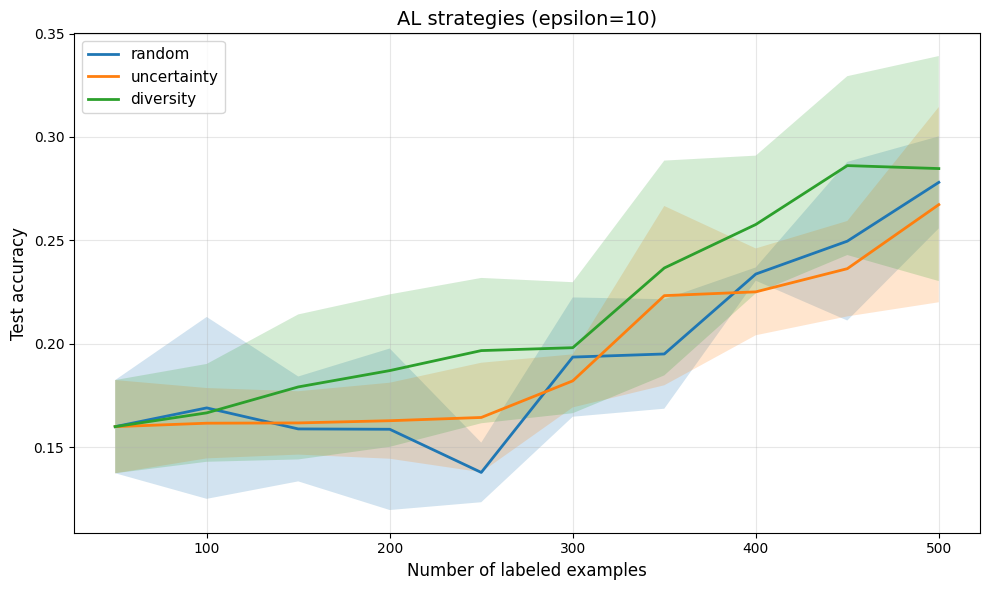

✓ Saved: /content/drive/MyDrive/AL_Results/secondary/summary_e10.json
✓ Saved: /content/drive/MyDrive/AL_Results/secondary/summary_e10.csv
✓ Saved: /content/drive/MyDrive/AL_Results/secondary/al_learning_curves_e10.png
All summaries generated and saved to: /content/drive/MyDrive/AL_Results/secondary


In [ ]:
# ============================================================
# CELL 9: Post-process and visualize
# ============================================================
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

DIR = SAVE_DIR + "/secondary"  # already defined

# helper to load result file for a given epsilon (int percent)
def load_results_for_epsilon(save_dir, e_percent):
    fname = os.path.join(save_dir, f"al_results_e{e_percent}.pkl")
    if not os.path.exists(fname):
        raise FileNotFoundError(f"{fname} not found")
    with open(fname, "rb") as f:
        all_results = pickle.load(f)
    return all_results

# process all saved result files found in SAVE_DIR matching pattern al_results_e*.pkl
files = [f for f in os.listdir(DIR) if f.startswith('al_results_e') and f.endswith('.pkl')]
print(f"Found result files: {files}")

for f in files:
    path = os.path.join(DIR, f)
    with open(path, "rb") as fh:
        all_results = pickle.load(fh)
    e_str = f.split('al_results_e')[-1].split('.pkl')[0]
    # normalize e label
    try:
        e_val = int(e_str)
    except Exception:
        e_val = e_str

    summary = {}
    for s in all_results:
        # collect all label counts from all reps
        labels_grid = sorted({n for rep in all_results[s] for n,_ in rep})
        mats = []
        for rep in all_results[s]:
            acc_map = {n:acc for n,acc in rep}
            # create accs aligned to labels_grid by forward-fill using last available
            accs = []
            for n in labels_grid:
                if n in acc_map:
                    accs.append(acc_map[n])
                else:
                    # find the largest key <= n
                    keys = [k for k in acc_map.keys() if k <= n]
                    if len(keys) == 0:
                        accs.append(0.0)
                    else:
                        accs.append(acc_map[max(keys)])
            mats.append(accs)
        mats = np.array(mats)
        mean = mats.mean(0)
        ci95 = 1.96 * mats.std(0, ddof=1) / np.sqrt(max(1, mats.shape[0]))
        summary[s] = {'labels': labels_grid, 'mean': mean.tolist(), 'ci': ci95.tolist()}

    # Save JSON
    json_path = os.path.join(DIR, f"summary_e{e_val}.json")
    with open(json_path, "w") as fjson:
        json.dump(summary, fjson, indent=2)

    # Save CSV
    rows = []
    for s in summary:
        for n, m, c in zip(summary[s]['labels'], summary[s]['mean'], summary[s]['ci']):
            rows.append({"strategy": s, "labels": n, "accuracy_mean": m, "accuracy_ci95": c})
    csv_path = os.path.join(DIR, f"summary_e{e_val}.csv")
    pd.DataFrame(rows).to_csv(csv_path, index=False)

    # Plot
    plt.figure(figsize=(10, 6))
    for s in summary:
        x = summary[s]['labels']
        y = summary[s]['mean']
        ci = summary[s]['ci']
        plt.plot(x, y, label=s, linewidth=2)
        plt.fill_between(x, np.array(y) - np.array(ci), np.array(y) + np.array(ci), alpha=0.2)
    plt.xlabel("Number of labeled examples", fontsize=12)
    plt.ylabel("Test accuracy", fontsize=12)
    plt.title(f"AL strategies (epsilon={e_val})", fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plot_path = os.path.join(DIR, f"al_learning_curves_e{e_val}.png")
    plt.savefig(plot_path, dpi=200, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: {json_path}")
    print(f"✓ Saved: {csv_path}")
    print(f"✓ Saved: {plot_path}")

print(f"{'='*60}")
print(f"All summaries generated and saved to: {DIR}")
print(f"{'='*60}")


In [ ]:
# ============================================================
# CELL 10: Secondary Experiment: Uniform Random Epsilon per Rep
# ============================================================

# Use a small subset for quick testing
config_secondary = {
    'save_dir': SAVE_DIR + "/tertiary",  # separate folder to avoid overwriting
    'subset': 4000,                       # small subset
    'initial_labels': 100,
    'labeling_budget': 1000,
    'query_batch': 50,
    'max_epochs': 5,                       # fewer epochs for speed
    'strategies': ['random', 'uncertainty', 'diversity'],
    'epsilons': [0.10, 0.15],                    # pick a single epsilon
    'replications': 3,                     # small number of reps
    'seed': 123,
    'early_stopping': True,
    'patience': 2,
    'verbose': True,
    'sample_epsilon_per_rep': True         # uniform random epsilon per replication
}

os.makedirs(config_secondary['save_dir'], exist_ok=True)

# Run the experiment
save_dir_secondary = run_experiment(config_secondary)
print(f"Secondary experiment completed. Results saved to: {save_dir_secondary}")

# ============================================================
# Load and inspect
# ============================================================
import pickle, json, os, numpy as np, pandas as pd

# Load results
files = [f for f in os.listdir(save_dir_secondary) if f.startswith('al_results_e') and f.endswith('.pkl')]
for f in files:
    path = os.path.join(save_dir_secondary, f)
    with open(path, "rb") as fh:
        all_results = pickle.load(fh)
    print(f"\nResults for file: {f}")
    for strat, reps in all_results.items():
        accs = [r[-1][1] for r in reps]  # final accuracy of each replication
        print(f"  Strategy: {strat}, mean final accuracy: {np.mean(accs):.3f}, std: {np.std(accs):.3f}")


Using device: cuda
Experiment configuration:
  Dataset size: 4000
  Initial labels: 100
  Labeling budget: 1000
  Max epochs: 5
  Strategies: ['random', 'uncertainty', 'diversity']
  Epsilon values: [0.1, 0.15] (if sampling enabled, values may be drawn per-replication)
  Replications: 3
  Save directory: /content/drive/MyDrive/AL_Results/tertiary
Total experiments (approx): 18
Running epsilon = 0.1
  Rep 1/3, Strategy: random, eps=0.0696
Round 0: 100 labels, accuracy=0.1381
Round 1: 150 labels, accuracy=0.1361
Round 2: 200 labels, accuracy=0.1219
Round 3: 250 labels, accuracy=0.1246
Round 4: 300 labels, accuracy=0.1433
Round 5: 350 labels, accuracy=0.1952
Round 6: 400 labels, accuracy=0.2360
Round 7: 450 labels, accuracy=0.2234
Round 8: 500 labels, accuracy=0.2167
Round 9: 550 labels, accuracy=0.2965
Round 10: 600 labels, accuracy=0.3380
Round 11: 650 labels, accuracy=0.3390
Round 12: 700 labels, accuracy=0.3107
Round 13: 750 labels, accuracy=0.3627
Round 14: 800 labels, accuracy=0.364

Found result files: ['al_results_e10.pkl', 'al_results_e15.pkl']


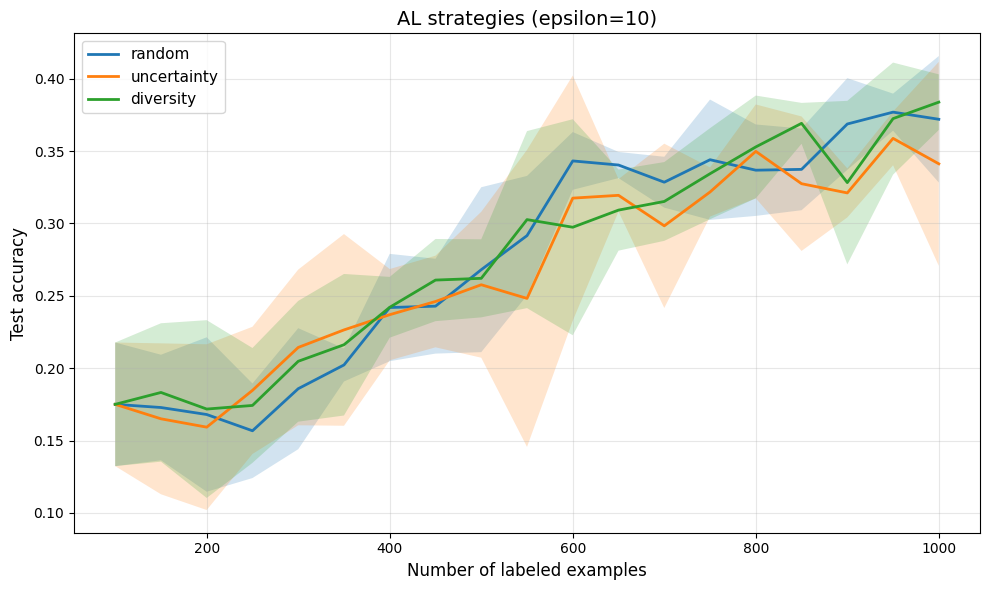

✓ Saved: /content/drive/MyDrive/AL_Results/tertiary/summary_e10.json
✓ Saved: /content/drive/MyDrive/AL_Results/tertiary/summary_e10.csv
✓ Saved: /content/drive/MyDrive/AL_Results/tertiary/al_learning_curves_e10.png


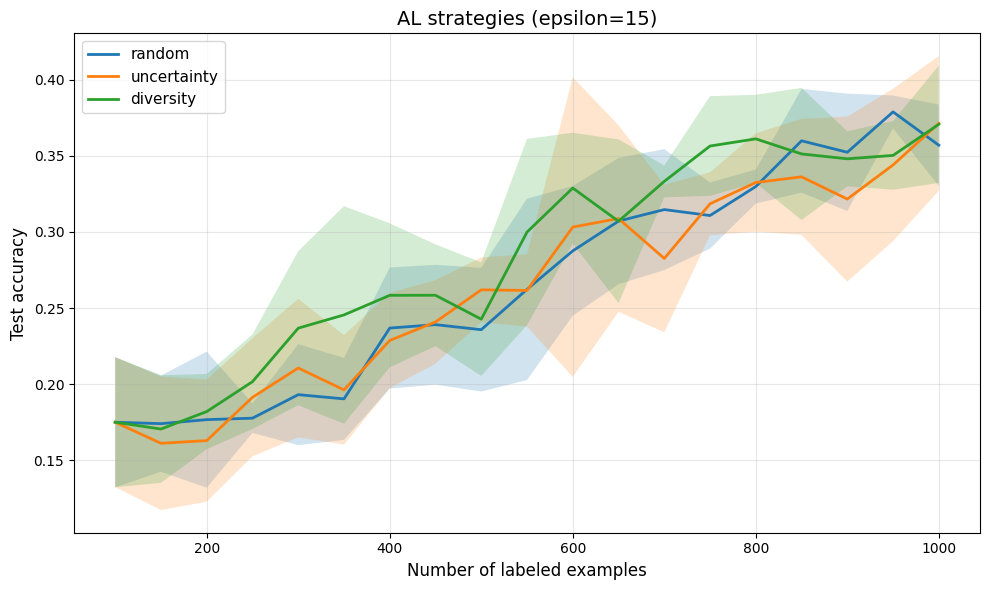

✓ Saved: /content/drive/MyDrive/AL_Results/tertiary/summary_e15.json
✓ Saved: /content/drive/MyDrive/AL_Results/tertiary/summary_e15.csv
✓ Saved: /content/drive/MyDrive/AL_Results/tertiary/al_learning_curves_e15.png
All summaries generated and saved to: /content/drive/MyDrive/AL_Results/tertiary


In [ ]:
# ============================================================
# CELL 11: Post-process and visualize
# ============================================================
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

SUB_DIR = "/tertiary"

DIR = SAVE_DIR + SUB_DIR  # already defined

# helper to load result file for a given epsilon (int percent)
def load_results_for_epsilon(save_dir, e_percent):
    fname = os.path.join(save_dir, f"al_results_e{e_percent}.pkl")
    if not os.path.exists(fname):
        raise FileNotFoundError(f"{fname} not found")
    with open(fname, "rb") as f:
        all_results = pickle.load(f)
    return all_results

# process all saved result files found in SAVE_DIR matching pattern al_results_e*.pkl
files = [f for f in os.listdir(DIR) if f.startswith('al_results_e') and f.endswith('.pkl')]
print(f"Found result files: {files}")

for f in files:
    path = os.path.join(DIR, f)
    with open(path, "rb") as fh:
        all_results = pickle.load(fh)
    e_str = f.split('al_results_e')[-1].split('.pkl')[0]
    # normalize e label
    try:
        e_val = int(e_str)
    except Exception:
        e_val = e_str

    summary = {}
    for s in all_results:
        # collect all label counts from all reps
        labels_grid = sorted({n for rep in all_results[s] for n,_ in rep})
        mats = []
        for rep in all_results[s]:
            acc_map = {n:acc for n,acc in rep}
            # create accs aligned to labels_grid by forward-fill using last available
            accs = []
            for n in labels_grid:
                if n in acc_map:
                    accs.append(acc_map[n])
                else:
                    # find the largest key <= n
                    keys = [k for k in acc_map.keys() if k <= n]
                    if len(keys) == 0:
                        accs.append(0.0)
                    else:
                        accs.append(acc_map[max(keys)])
            mats.append(accs)
        mats = np.array(mats)
        mean = mats.mean(0)
        ci95 = 1.96 * mats.std(0, ddof=1) / np.sqrt(max(1, mats.shape[0]))
        summary[s] = {'labels': labels_grid, 'mean': mean.tolist(), 'ci': ci95.tolist()}

    # Save JSON
    json_path = os.path.join(DIR, f"summary_e{e_val}.json")
    with open(json_path, "w") as fjson:
        json.dump(summary, fjson, indent=2)

    # Save CSV
    rows = []
    for s in summary:
        for n, m, c in zip(summary[s]['labels'], summary[s]['mean'], summary[s]['ci']):
            rows.append({"strategy": s, "labels": n, "accuracy_mean": m, "accuracy_ci95": c})
    csv_path = os.path.join(DIR, f"summary_e{e_val}.csv")
    pd.DataFrame(rows).to_csv(csv_path, index=False)

    # Plot
    plt.figure(figsize=(10, 6))
    for s in summary:
        x = summary[s]['labels']
        y = summary[s]['mean']
        ci = summary[s]['ci']
        plt.plot(x, y, label=s, linewidth=2)
        plt.fill_between(x, np.array(y) - np.array(ci), np.array(y) + np.array(ci), alpha=0.2)
    plt.xlabel("Number of labeled examples", fontsize=12)
    plt.ylabel("Test accuracy", fontsize=12)
    plt.title(f"AL strategies (epsilon={e_val})", fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plot_path = os.path.join(DIR, f"al_learning_curves_e{e_val}.png")
    plt.savefig(plot_path, dpi=200, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: {json_path}")
    print(f"✓ Saved: {csv_path}")
    print(f"✓ Saved: {plot_path}")

print(f"{'='*60}")
print(f"All summaries generated and saved to: {DIR}")
print(f"{'='*60}")


In [ ]:
# ============================================================
# CELL 12: Final Robust Experiment (Full Scale, Stochastic Noise)
# ============================================================

config_robust = {
    'save_dir': SAVE_DIR + "/robust_stochastic",
    'subset': None,
    'initial_labels': 100,
    'labeling_budget': 2000,
    'query_batch': 100,
    'max_epochs': 10,
    'strategies': ['random', 'uncertainty', 'diversity'],
    'epsilons': [0.15],
    'sample_epsilon_per_rep': True,
    'replications': 5,
    'seed': 999, # New seed to ensure independence
    'early_stopping': True,
    'patience': 3,
    'verbose': True
}

# Run it
print(f"Starting Robust Stochastic Run...")
results_dir = run_experiment(config_robust)
print(f"\n✓ Robust results saved to: {results_dir}")

Starting Robust Stochastic Run...
Using device: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Experiment configuration:
  Dataset size: 50000
  Initial labels: 100
  Labeling budget: 2000
  Max epochs: 10
  Strategies: ['random', 'uncertainty', 'diversity']
  Epsilon values: [0.15] (if sampling enabled, values may be drawn per-replication)
  Replications: 5
  Save directory: /content/drive/MyDrive/AL_Results/robust_stochastic
Total experiments (approx): 15
Running epsilon = 0.15
  Rep 1/5, Strategy: random, eps=0.1205
  Early stopping at epoch 7
Round 0: 100 labels, accuracy=0.1669
Round 1: 200 labels, accuracy=0.2478
Round 2: 300 labels, accuracy=0.3061
Round 3: 400 labels, accuracy=0.3175
Round 4: 500 labels, accuracy=0.3476
Round 5: 600 labels, accuracy=0.3837
Round 6: 700 labels, accuracy=0.3837
Round 7: 800 labels, accuracy=0.3806
Round 8: 900 labels, accuracy=0.3920
Round 9: 1000 labels, accuracy=0.4130
Round 10: 1100 labels, accuracy=0.4281
Round 11: 1200 labels, accuracy=0.4663
Round 12: 1300 labels, accuracy=0.4686
Round 13: 1400 labels, accuracy=0.4358
Round 14: 1500 

Found result files: ['al_results_e15.pkl']


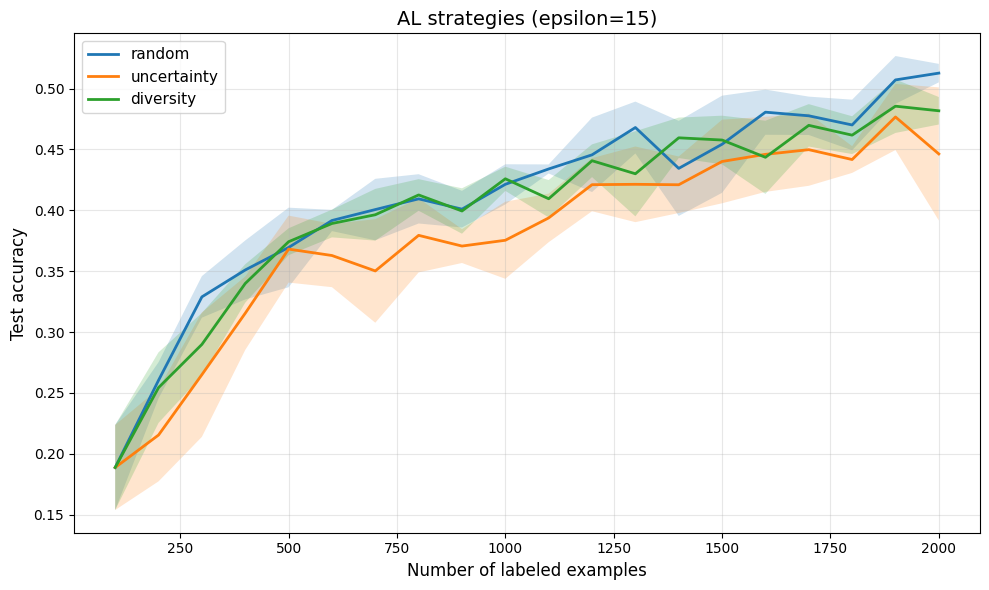

✓ Saved: /content/drive/MyDrive/AL_Results/robust_stochastic/summary_e15.json
✓ Saved: /content/drive/MyDrive/AL_Results/robust_stochastic/summary_e15.csv
✓ Saved: /content/drive/MyDrive/AL_Results/robust_stochastic/al_learning_curves_e15.png
All summaries generated and saved to: /content/drive/MyDrive/AL_Results/robust_stochastic


In [ ]:
# ============================================================
# CELL 13: Post-process and visualize
# ============================================================
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

SUB_DIR = "/robust_stochastic"

DIR = SAVE_DIR + SUB_DIR

# Process all saved result files found in SAVE_DIR matching pattern al_results_e*.pkl
files = [f for f in os.listdir(DIR) if f.startswith('al_results_e') and f.endswith('.pkl')]
print(f"Found result files: {files}")

for f in files:
    path = os.path.join(DIR, f)
    with open(path, "rb") as fh:
        all_results = pickle.load(fh)
    e_str = f.split('al_results_e')[-1].split('.pkl')[0]
    try:
        e_val = int(e_str)
    except Exception:
        e_val = e_str

    summary = {}
    for s in all_results:
        labels_grid = sorted({n for rep in all_results[s] for n,_ in rep})
        mats = []
        for rep in all_results[s]:
            acc_map = {n:acc for n,acc in rep}
            accs = []
            for n in labels_grid:
                if n in acc_map:
                    accs.append(acc_map[n])
                else:
                    keys = [k for k in acc_map.keys() if k <= n]
                    if len(keys) == 0:
                        accs.append(0.0)
                    else:
                        accs.append(acc_map[max(keys)])
            mats.append(accs)
        mats = np.array(mats)
        mean = mats.mean(0)
        ci95 = 1.96 * mats.std(0, ddof=1) / np.sqrt(max(1, mats.shape[0]))
        summary[s] = {'labels': labels_grid, 'mean': mean.tolist(), 'ci': ci95.tolist()}

    # Save JSON
    json_path = os.path.join(DIR, f"summary_e{e_val}.json")
    with open(json_path, "w") as fjson:
        json.dump(summary, fjson, indent=2)

    # Save CSV
    rows = []
    for s in summary:
        for n, m, c in zip(summary[s]['labels'], summary[s]['mean'], summary[s]['ci']):
            rows.append({"strategy": s, "labels": n, "accuracy_mean": m, "accuracy_ci95": c})
    csv_path = os.path.join(DIR, f"summary_e{e_val}.csv")
    pd.DataFrame(rows).to_csv(csv_path, index=False)

    # Plot
    plt.figure(figsize=(10, 6))
    for s in summary:
        x = summary[s]['labels']
        y = summary[s]['mean']
        ci = summary[s]['ci']
        plt.plot(x, y, label=s, linewidth=2)
        plt.fill_between(x, np.array(y) - np.array(ci), np.array(y) + np.array(ci), alpha=0.2)
    plt.xlabel("Number of labeled examples", fontsize=12)
    plt.ylabel("Test accuracy", fontsize=12)
    plt.title(f"AL strategies (epsilon={e_val})", fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plot_path = os.path.join(DIR, f"al_learning_curves_e{e_val}.png")
    plt.savefig(plot_path, dpi=200, bbox_inches='tight')
    plt.show()

    print(f"✓ Saved: {json_path}")
    print(f"✓ Saved: {csv_path}")
    print(f"✓ Saved: {plot_path}")

print(f"{'='*60}")
print(f"All summaries generated and saved to: {DIR}")
print(f"{'='*60}")


In [ ]:
# ============================================================
# CELL 14: Statistical Analysis of Full Scale, Stochastic Noise Experiment
# ============================================================

import numpy as np
import pandas as pd
import pickle
import os
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load the specific stochastic results
# Note: The file is named 'e15' because 0.15 was the upper bound config parameter
stochastic_path = os.path.join(SAVE_DIR, "robust_stochastic", "al_results_e15.pkl")
print(f"Loading results from: {stochastic_path}")

with open(stochastic_path, "rb") as f:
    all_results = pickle.load(f)

# Parse into DataFrame
data_rows = []
for strat, reps in all_results.items():
    for rep_idx, rep_data in enumerate(reps):
        for labels, acc in rep_data:
            data_rows.append({
                "strategy": strat,
                "rep": rep_idx,
                "labels": labels,
                "accuracy": acc,
                "condition": "Stochastic (0-15%)"
            })

df = pd.DataFrame(data_rows)
print(f"Data loaded: {len(df)} rows across {len(df['rep'].unique())} replications.")

# Compute AULC (Area Under Learning Curve)
print("\nComputing AULC per replication...")
aulc_rows = []
# Group by strategy and replication (condition is constant)
for (strat, rep), g in df.groupby(["strategy", "rep"]):
    g_sorted = g.sort_values("labels")
    # Trapz computes area under the curve
    auc_val = np.trapz(g_sorted["accuracy"], g_sorted["labels"])
    aulc_rows.append({
        "strategy": strat,
        "rep": rep,
        "aulc": auc_val
    })

aulc_df = pd.DataFrame(aulc_rows)
print(aulc_df.head())

# Run One-Way ANOVA (Strategy)
print("\n============================")
print("ANOVA: Stochastic Noise Condition")
print("============================")

model = ols("aulc ~ C(strategy)", data=aulc_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Tukey HSD Post-Hoc Test
print("\nPost-hoc Tukey HSD:")
tukey = pairwise_tukeyhsd(aulc_df["aulc"], aulc_df["strategy"])
print(tukey)

# Effect Sizes (Eta-squared & Cohen's d)
def etasquared(anova_tbl):
    return anova_tbl.loc["C(strategy)", "sum_sq"] / anova_tbl["sum_sq"].sum()

def cohend(x, y):
    # Pooled standard deviation
    n1, n2 = len(x), len(y)
    var1, var2 = np.var(x, ddof=1), np.var(y, ddof=1)
    pool_sd = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (np.mean(x) - np.mean(y)) / pool_sd

print("\n============================")
print("Effect Sizes")
print("============================")

eta2 = etasquared(anova_table)
print(f"η² (Global effect size of strategy): {eta2:.3f}")
print("Interpretation: <0.06 (small), 0.06-0.14 (medium), >0.14 (large)\n")

strategies = aulc_df["strategy"].unique()
for i, s1 in enumerate(strategies):
    for s2 in strategies[i+1:]:
        group1 = aulc_df[aulc_df.strategy == s1]["aulc"]
        group2 = aulc_df[aulc_df.strategy == s2]["aulc"]

        d = cohend(group1, group2)
        print(f"Cohen's d ({s1} vs {s2}): {d:.3f}")

Loading results from: /content/drive/MyDrive/AL_Results/robust_stochastic/al_results_e15.pkl
Data loaded: 300 rows across 5 replications.

Computing AULC per replication...
    strategy  rep     aulc
0  diversity    0  771.985
1  diversity    1  752.450
2  diversity    2  765.830
3  diversity    3  782.105
4  diversity    4  764.910

ANOVA: Stochastic Noise Condition
                   sum_sq    df         F    PR(>F)
C(strategy)  10329.653303   2.0  12.74649  0.001075
Residual      4862.352020  12.0       NaN       NaN

Post-hoc Tukey HSD:


/tmp/ipython-input-1321323608.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_val = np.trapz(g_sorted["accuracy"], g_sorted["labels"])


     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1     group2   meandiff p-adj   lower    upper   reject
--------------------------------------------------------------
diversity      random   18.099 0.3612 -15.8656  52.0636  False
diversity uncertainty  -44.366 0.0116 -78.3306 -10.4014   True
   random uncertainty  -62.465  0.001 -96.4296 -28.5004   True
--------------------------------------------------------------

Effect Sizes
η² (Global effect size of strategy): 0.680
Interpretation: <0.06 (small), 0.06-0.14 (medium), >0.14 (large)

Cohen's d (diversity vs random): -0.814
Cohen's d (diversity vs uncertainty): 3.382
Cohen's d (random vs uncertainty): 2.666
